In [12]:
import os
import queue
import threading
import glob
import tqdm

import pandas as pd
import numpy as np

import librosa

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.base import clone
from sklearn.mixture import GaussianMixture
from sklearn.externals import joblib
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, confusion_matrix

%matplotlib inline

In [2]:
def evaluate_gmms(vec, n_gaussian, covariance = None):
    if covariance is None:
        covariance = ['spherical', 'tied', 'diag', 'full']
    best_option = None
    best_bic = 1e6
    for cov in covariance:
        for i in range(1, n_gaussian):
            gmm = GaussianMixture(n_components = i, covariance_type=cov)
            gmm = gmm.fit(vec)
            current_bic = gmm.bic(vec)
            if current_bic < best_bic:
                best_bic = current_bic
                best_option = {"n_components" : i, "covariance_type":cov}
    return best_option

In [3]:
def evaluate_gmms_opt(vec, n_gaussian, covariance = None, step = 3, filename=None):
    if covariance is None:
        covariance = ['spherical', 'tied', 'diag', 'full']
        
    best_option = {}
    best_bic = 1e9
    iter_wo_opt = 0
    for cov in covariance:
        for i in range(1, n_gaussian):
            gmm = GaussianMixture(n_components = i, covariance_type=cov)
            gmm = gmm.fit(vec)
            current_bic = gmm.bic(vec)
            if current_bic < best_bic:
                best_bic = current_bic
                best_option = {"n_components" : i, "covariance_type":cov}
                iter_wo_opt = 0
            else:
                iter_wo_opt += 1

            if iter_wo_opt == step:
                break
            if i == n_gaussian-1:
                print(filename)
    return best_option

In [8]:
os.system("CALL activate machine_learning && python extract_gmm1d.py 0")

1

In [4]:
# def extract_cqt(input_path):
#     y, sr = librosa.load(input_path, sr=None, mono = True)

#     if sr != 22050:
#         y = librosa.resample(y, sr, 22050)
#         sr = 22050

#     cqt = librosa.core.cqt(y=y, 
#                             sr=sr,
#                             hop_length=512)
    
#     return librosa.power_to_db(cqt)

# def process_audio_cqt():
#     while True:
#         input_path = q.get()
#         if input_path is None:
#             break
        
#         filename = os.path.basename(input_path)[:-4]
#         output_path = os.path.join("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_audio", "cqt", filename+".npy")
        
#         cqt = extract_cqt(input_path)
                
#         np.save(output_path, cqt)
        
#         q.task_done()
        
# q = queue.Queue()
# num_worker_threads = 5

# print("launch thread")
# threads = []
# for i in range(num_worker_threads):
#     t = threading.Thread(target=process_audio_cqt)
#     t.start()
#     threads.append(t)
    
# print("feeding queue")
# for audio_path in glob.glob(os.path.join("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_small/*/*.mp3")):
#     filename = os.path.basename(audio_path)[:-4]
#     output_path = os.path.join("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_audio", "cqt", filename+".npy")
#     if not os.path.exists(output_path):
#         q.put(audio_path)
# q.join()

# for i in range(num_worker_threads):
#     q.put(None)

# for t in threads:
#     t.join()
# print("end")

In [5]:
# Exploration

In [6]:
a = "F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_audio/cqt/000002.npy"

In [7]:
x = np.load(a)
x = np.swapaxes(x, 0, 1)

In [8]:
x.shape

(1291, 84)

In [9]:
x -= x.min()
x /= x.max()

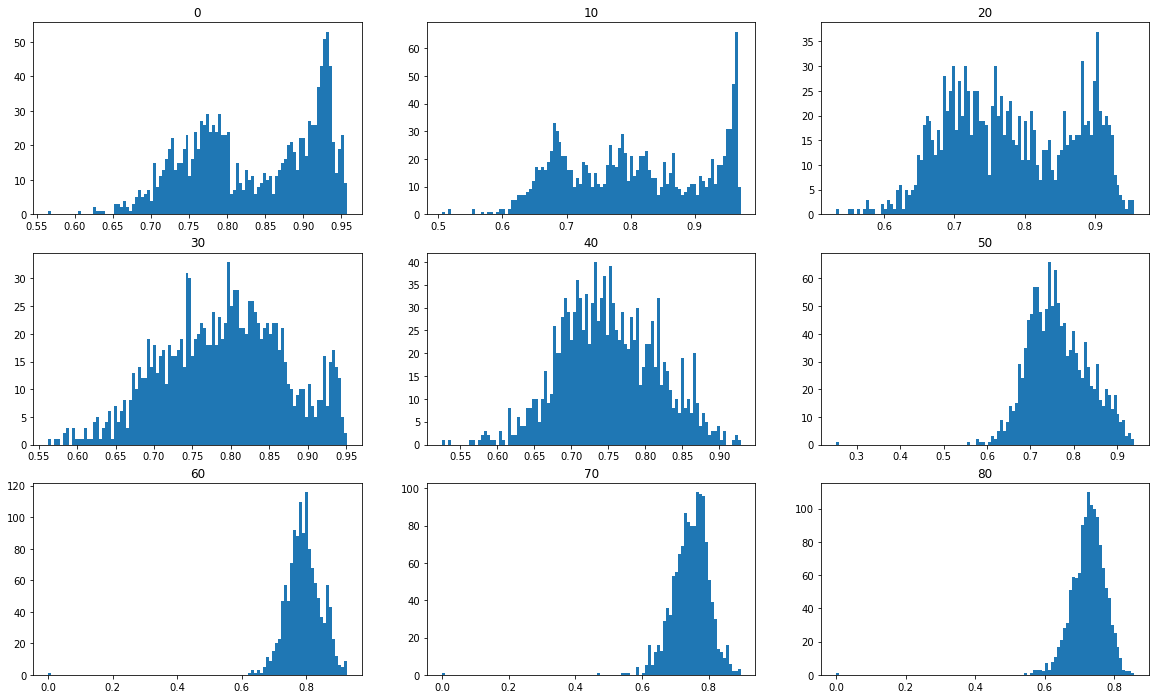

In [10]:
plt.figure(figsize=(20,12))
for n, i in enumerate(range(0, 84, 10)):
    plt.subplot(3,3,n+1)
    plt.hist(x[:, i], bins=100)
    plt.title(i)
plt.show()

# GMM 1D

In [11]:
best_option = []
best_bic = 1e6
result = {}
cv_types = ['spherical', 'tied', 'diag', 'full']
x_axis= list(range(2, 40, 2))
for cv_type in cv_types:
    bic_list = []
    for i in x_axis:
        gmm = GaussianMixture(n_components = i, covariance_type=cv_type)
        gmm = gmm.fit(x[:, 16].reshape(-1,1))
#         print(i, gmm.bic(X))
        current_bic = gmm.bic(x[:, 16].reshape(-1,1))
        bic_list.append(current_bic)
        if current_bic < best_bic:
            best_bic = current_bic
            best_option = {"n_components" : i, "covariance_type":cv_type}
    result[cv_type] = bic_list

In [12]:
print(gmm.weights_.flatten() )
print(gmm.weights_.shape)
print("")
print(gmm.means_.flatten() )
print(gmm.means_.shape)
print("")
print(gmm.covariances_.flatten() )
print(gmm.covariances_.shape)
print("")
print(gmm.precisions_.flatten() )
print(gmm.precisions_.shape)

[0.01554335 0.02926675 0.03323974 0.0374907  0.0314154  0.01004441
 0.03160076 0.01597658 0.02238015 0.03281471 0.02925257 0.03808375
 0.03778852 0.02686134 0.00154919 0.02709514 0.02844214 0.02569941
 0.00310003 0.03609152 0.02138223 0.02161625 0.02226221 0.0318827
 0.02473185 0.01981297 0.02291111 0.02015263 0.03858026 0.02031602
 0.03476065 0.03429066 0.01525895 0.04677587 0.03162121 0.04065392
 0.00672817 0.03252618]
(38,)

[0.78907432 0.91434739 0.67022845 0.86131095 0.73673264 0.59712429
 0.70321317 0.82526052 0.94539893 0.88733379 0.64734508 0.76415236
 0.68831713 0.62556335 0.52323946 0.84207638 0.9295999  0.7996034
 0.56743    0.89600897 0.72476773 0.86966657 0.65945836 0.77641518
 0.74430492 0.81614072 0.87860478 0.71194361 0.9347633  0.83181754
 0.75446821 0.92239869 0.80913839 0.67999842 0.8531753  0.69540063
 0.61037996 0.90537546]
(38, 1)

[9.61517154e-06 7.87358447e-06 1.33979292e-05 1.08570009e-05
 1.77968828e-05 4.04176736e-05 1.23296794e-05 9.37418410e-06
 2.55418780e

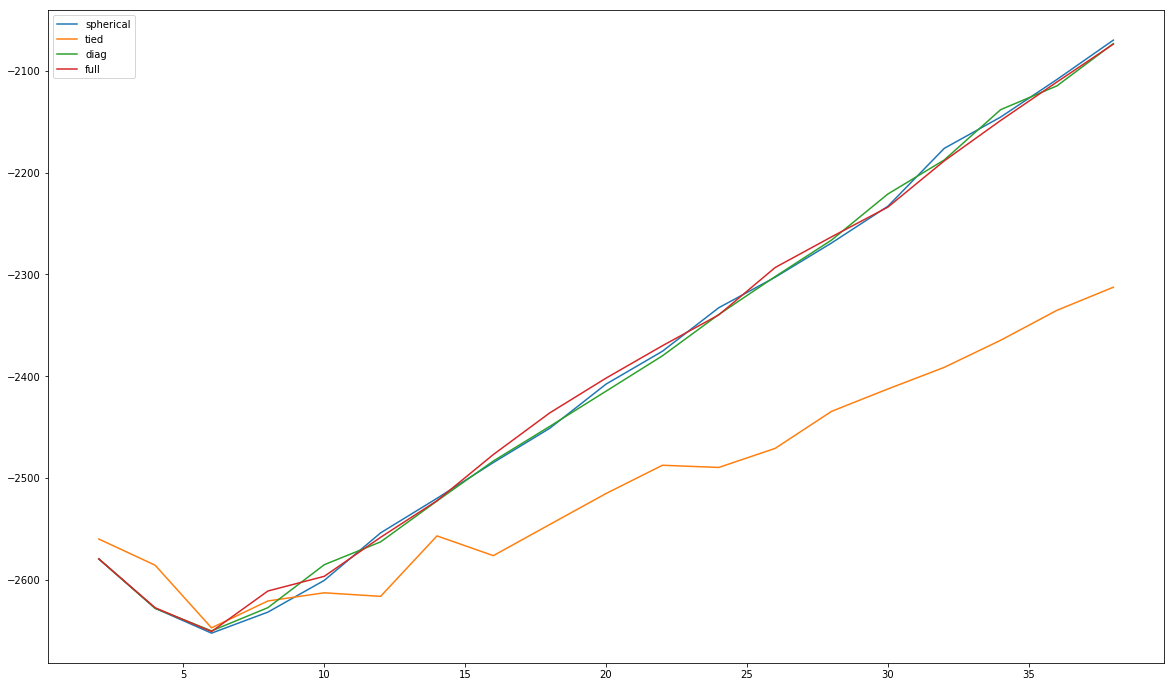

In [13]:
plt.figure(figsize=(20,12))
for cv_type in cv_types:
    plt.plot(x_axis, result[cv_type], label = cv_type)
plt.legend()
plt.show()

In [14]:
gmm = GaussianMixture(**best_option)
gmm = gmm.fit(x[:, 16].reshape(-1,1))
print(gmm.bic(x[:, 16].reshape(-1,1)))

-2652.4732128345595


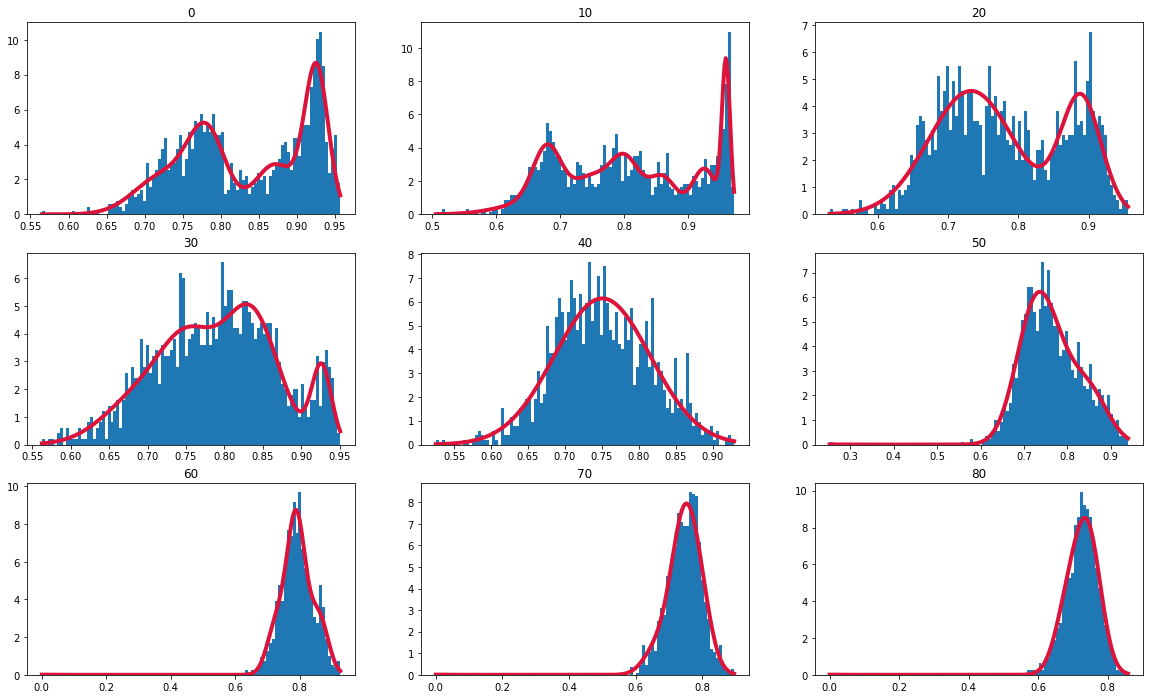

In [15]:
plt.figure(figsize=(20,12))

for n, i in enumerate(range(0, 84, 10)):
    best_estimator = evaluate_gmms(x[:, i].reshape(-1, 1), 10)
    gmm = GaussianMixture(**best_estimator).fit(x[:, i].reshape(-1,1))
    plt.subplot(3,3,n+1)
    x_axis = np.linspace(x[:, i].min(), x[:, i].max(), 250)
    y_axis = np.exp(gmm.score_samples(x_axis.reshape(-1,1)))
    plt.plot(x_axis, y_axis, color="crimson", lw=4, label="GMM")
    plt.hist(x[:, i], bins=100, normed=True)
    plt.title(i)
plt.show()

In [ ]:
def extract_gmm_to_df(start):
    data = {
        "file" : [],
        "mel" : [],
        "weigth" : [],
        "means" : [],
        "covariance" : []
    }

    for mfcc in glob.glob("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_audio/cqt/*.npy")[start:start+5]:
        filename = os.path.basename(mfcc)[:-4]

        x = np.load(mfcc)
        x = np.swapaxes(x, 0, 1)

        for i in range(84):
            best_bic = 1e6
            for n in range(1, 10):
                vec = x[:, i].reshape(-1, 1)
                gmm = GaussianMixture(n_components = n, covariance_type="full")
                gmm = gmm.fit(vec)
                current_bic = gmm.bic(vec)
                if current_bic < best_bic:
                    best_bic = current_bic
                    best_gmm = gmm
                    n_elem = n
            data["file"] += [filename]*n_elem
            data["mel"] += [i]*n_elem
            data["weigth"] += list(best_gmm.weights_.flatten())
            data["means"] += list(best_gmm.means_.flatten())
            data["covariance"] += list(best_gmm.covariances_.flatten())
    df = pd.DataFrame(data)
    df.to_csv("preprocessed_meta/gmm/{}.csv".format(start//100))

In [44]:
from multiprocessing import Process
from multiprocessing import Pool

In [15]:
for i in range(80):
    with open("launchers/{}.bat".format(i), "w") as file:
        file.write("CALL activate machine_learning\n") 
        file.write("cd..\n") 
        file.write("python extract_gmm1d.py {}\n".format(i*100)) 
#         file.write("PAUSE") 

In [25]:
frames = []
for csv in glob.glob("preprocessed_meta/gmm/*.csv"):
    frames.append(pd.read_csv(csv, index_col = 0))

df = pd.concat(frames).reset_index(drop=True)
df.to_csv("preprocessed_meta/gmm1d.csv")

In [3]:
df = pd.read_csv("preprocessed_meta/gmm1d.csv", index_col = 0)

C:\python36\envs\machine_learning\lib\site-packages\numpy\lib\arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df["var"] = df["covariance"].pow(1./2)

In [6]:
df.head()

,covariance,file,means,mel,weigth,var
0,1.522221,2,3.084317,0,0.322667,1.233783
1,3.868779,2,-8.445686,0,0.276151,1.966921
2,9.117836,2,-12.971197,0,0.209935,3.019575
3,4.560985,2,-1.267603,0,0.191247,2.135646
4,0.355961,2,3.533337,1,0.243417,0.596625


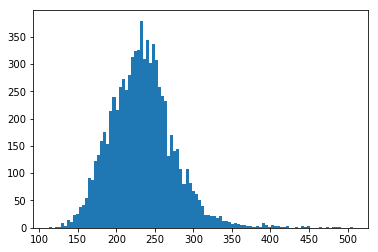

In [31]:
plt.hist(df.file.value_counts().values, bins=100)
plt.show()

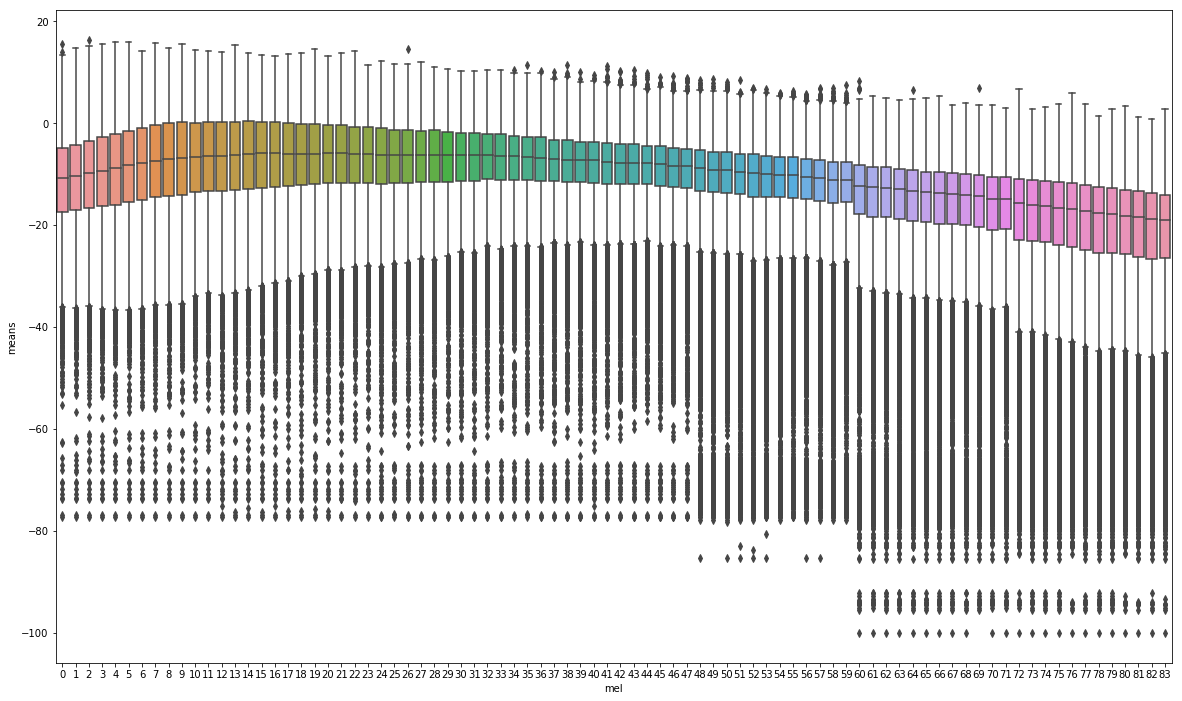

In [37]:
plt.figure(figsize=(20,12))
sns.boxplot(x="mel", y="means", data=df)
plt.show()

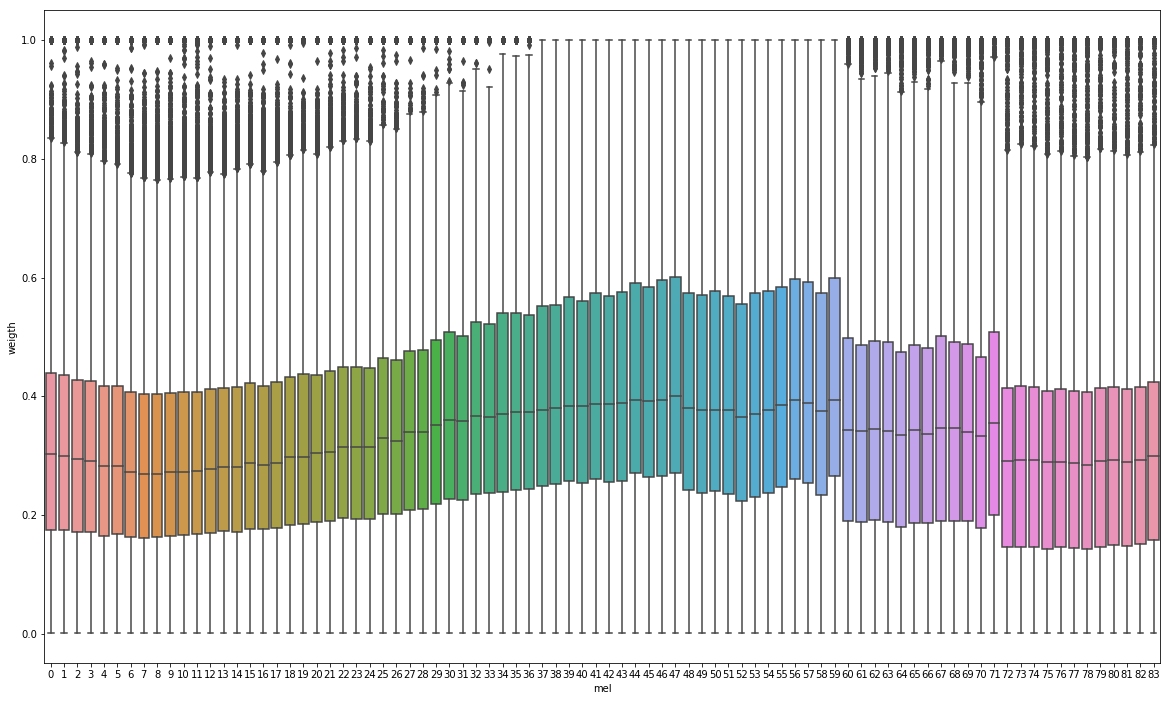

In [38]:
plt.figure(figsize=(20,12))
sns.boxplot(x="mel", y="weigth", data=df)
plt.show()

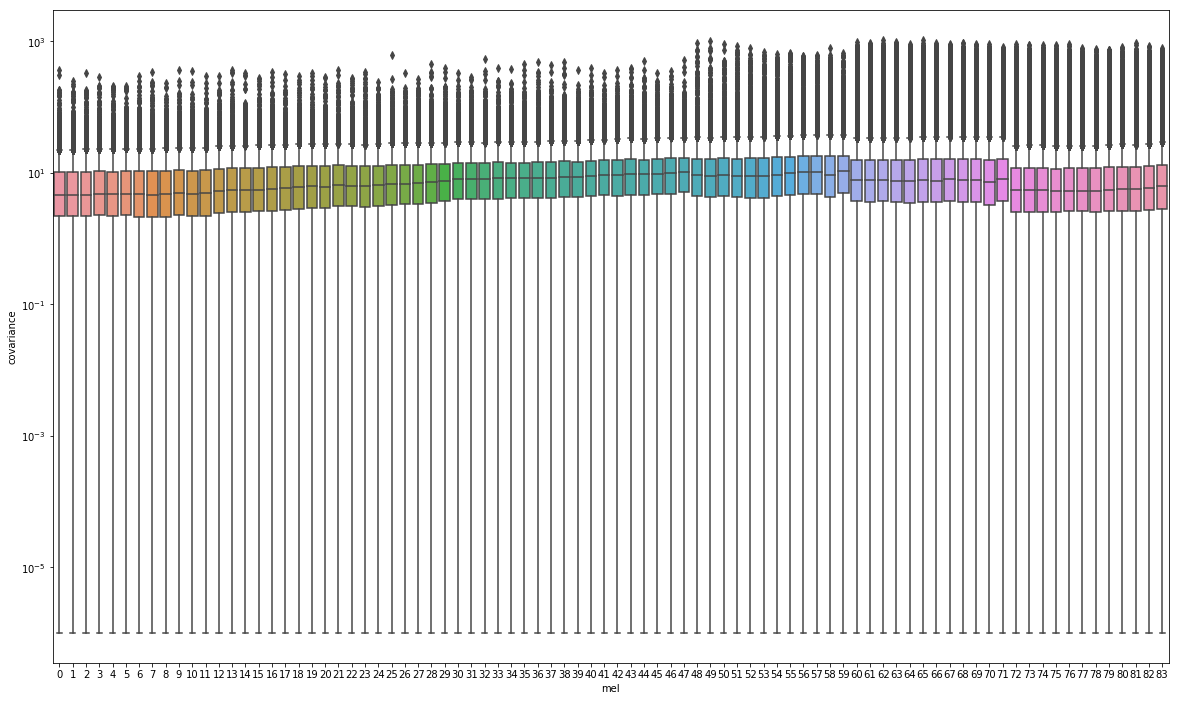

In [40]:
plt.figure(figsize=(20,12))
grid = sns.boxplot(x="mel", y="covariance", data=df)
grid.set(yscale="log")
plt.show()

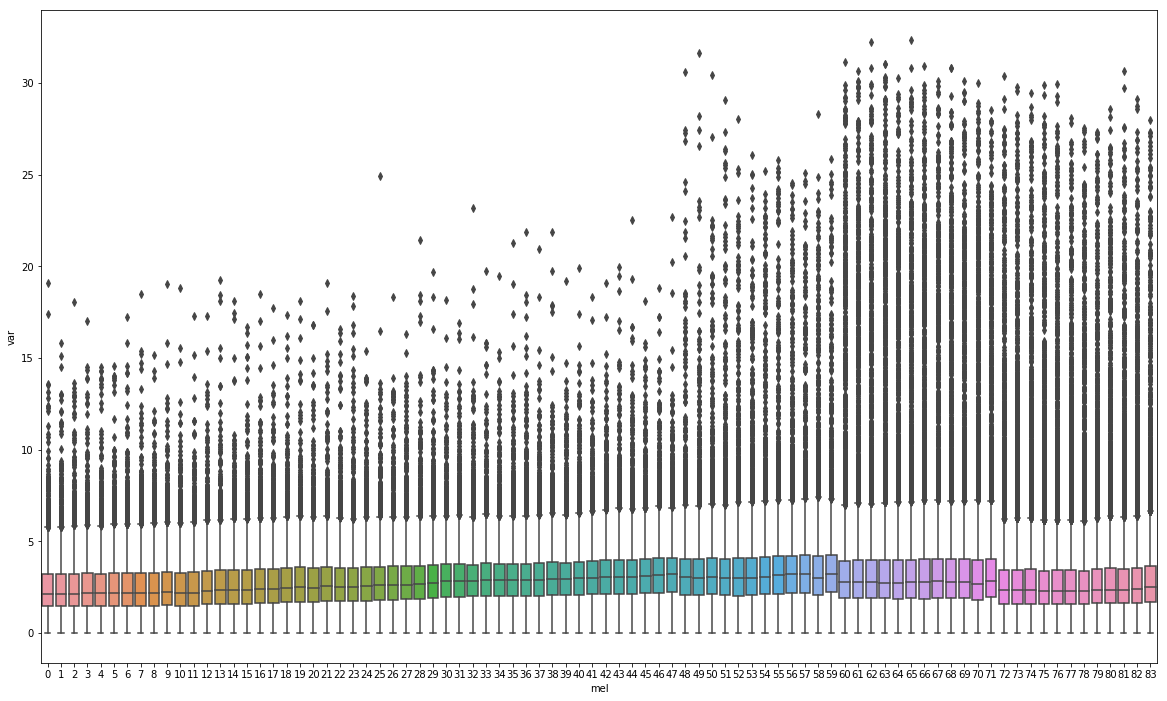

In [42]:
plt.figure(figsize=(20,12))
grid = sns.boxplot(x="mel", y="var", data=df)
# grid.set(yscale="log")
plt.show()

In [9]:
X = df[["means", "weigth", "var"]].values

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# tsne = TSNE(n_components=2)
# X_embedded = tsne.fit_transform(X)

In [19]:
from sklearn.cluster import MiniBatchKMeans
score = []
for n_clusters in range(100, 2000, 50):
    mdl = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10000)
    label = mdl.fit_predict(X)
    a = silhouette_score(X, label, sample_size =10000)
    print(n_clusters, a)
    score.append(a)

100 0.20314097245415866
150 0.20363780450685443
200 0.19937076459736283
250 0.16035657000620288
300 0.15528455165646446
350 0.13974580805570622
400 0.15137169491939326
450 0.11844927699586773
500 0.12005931898339839
550 0.10456262948722685
600 0.11236162958265813
650 0.1037736129660943
700 0.1340129878194379
750 0.1010880158662929
800 0.09909251050006851
850 0.10526511702736195
900 0.09393899029812944
950 0.09943948311996485
1000 0.10359846249967256
1050 0.07407486255897526
1100 0.08758552629525083
1150 0.09658780895889806
1200 0.09218389334252998
1250 0.12091211728808329
1300 0.09617559738660222
1350 0.09050852743403048
1400 0.08477706895251026
1450 0.07622379182390544
1500 0.0918751639281775
1550 0.10427796061384118
1600 0.1123053667972999
1650 0.07708698697794138
1700 0.10658127525091729
1750 0.10284748206561678
1800 0.11273525031337747
1850 0.08033040202105739
1900 0.06878268571671264
1950 0.1021570464674343


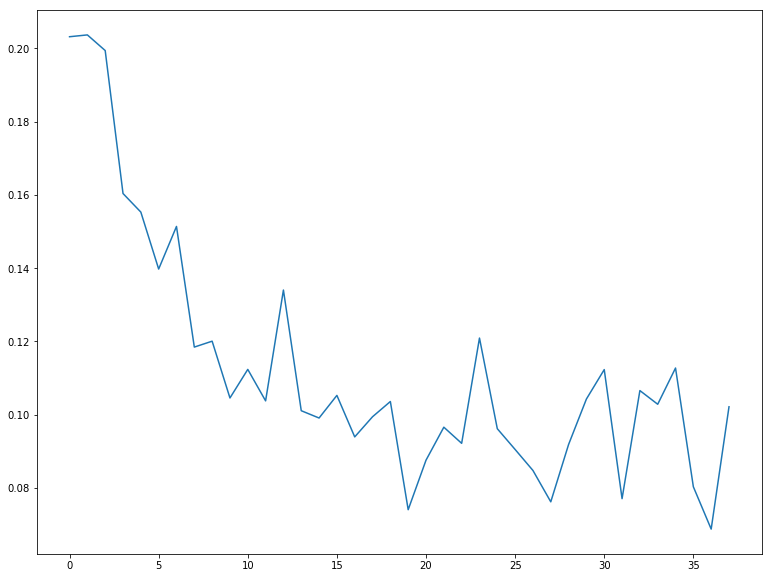

In [20]:
plt.figure(figsize=(13,10))
plt.plot(score)
plt.show()

In [21]:
mdl = MiniBatchKMeans(n_clusters=10000, batch_size=10000)
label = mdl.fit_predict(X)
a = silhouette_score(X, label, sample_size =10000)
print(n_clusters, a)

1950 0.10503615281629941


In [ ]:
plt.figure(figsize=(13,10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=color)
plt.title("TSNE sur les articles")
plt.xlabel('X axis')
plt.ylabel('Y axis')
plt.show()

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1868797 entries, 0 to 1868796
Data columns (total 6 columns):
covariance    float64
file          int64
means         float64
mel           int64
weigth        float64
var           float64
dtypes: float64(4), int64(2)
memory usage: 85.5 MB


# GMM 2D

In [93]:
cv_types = ['spherical', 'tied']
best_option = []
result = {}
best_bic = 1e6
x_axis= list(range(2, 20, 4))
for cv_type in cv_types:
    bic_list = []
    for i in x_axis:
        gmm = GaussianMixture(n_components = i, covariance_type=cv_type)
        gmm = gmm.fit(x)
        current_bic = gmm.bic(x)
        bic_list.append(current_bic)
        if current_bic < best_bic:
            best_bic = current_bic
            best_option = {"n_components" : i, "covariance_type":cv_type}
    result[cv_type] = bic_list

In [94]:
best_option

{'covariance_type': 'tied', 'n_components': 10}

In [95]:
option = {'covariance_type': 'tied', 'n_components': 10}
option2 = {'covariance_type': 'spherical', 'n_components': 10}
gmm = GaussianMixture(**option)
gmm = gmm.fit(x)
gmm2 = GaussianMixture(**option2)
gmm2 = gmm2.fit(x)

In [99]:
print(gmm.weights_.flatten() )
print(gmm.weights_.shape)
print("")
print(gmm.means_[0] )
print(gmm.means_.shape)
print("")
print(gmm.covariances_.flatten() )
print(gmm.covariances_.shape)
print("")
print(gmm.precisions_.flatten() )
print(gmm.precisions_.shape)

[0.123 0.133 0.082 0.121 0.048 0.071 0.114 0.061 0.125 0.122]
(10,)

[0.927 0.925 0.933 0.941 0.936 0.948 0.94  0.937 0.918 0.906 0.927 0.942
 0.944 0.933 0.916 0.889 0.893 0.892 0.88  0.864 0.841 0.849 0.856 0.87
 0.881 0.857 0.817 0.809 0.801 0.79  0.81  0.823 0.807 0.784 0.777 0.802
 0.828 0.813 0.763 0.762 0.754 0.739 0.771 0.803 0.792 0.768 0.775 0.809
 0.829 0.796 0.765 0.782 0.766 0.747 0.745 0.768 0.758 0.752 0.759 0.773
 0.79  0.768 0.76  0.754 0.747 0.737 0.754 0.769 0.759 0.75  0.75  0.756
 0.77  0.749 0.726 0.733 0.731 0.725 0.721 0.725 0.72  0.718 0.707 0.71 ]
(10, 84)

[0.002 0.001 0.001 ... 0.001 0.002 0.003]
(84, 84)

[1758.817 -769.127 -592.369 ...   26.073 -350.35   758.626]
(84, 84)


In [100]:
print(gmm2.weights_.flatten() )
print(gmm2.weights_.shape)
print("")
print(gmm2.means_[0] )
print(gmm2.means_.shape)
print("")
print(gmm2.covariances_.flatten() )
print(gmm2.covariances_.shape)
print("")
print(gmm2.precisions_.flatten() )
print(gmm2.precisions_.shape)

[0.001 0.135 0.156 0.11  0.16  0.042 0.155 0.069 0.071 0.101]
(10,)

[0.659 0.695 0.679 0.613 0.697 0.517 0.549 0.622 0.55  0.659 0.597 0.486
 0.636 0.588 0.66  0.56  0.602 0.42  0.601 0.587 0.597 0.656 0.681 0.7
 0.716 0.691 0.685 0.718 0.73  0.755 0.776 0.668 0.777 0.753 0.682 0.738
 0.717 0.63  0.619 0.621 0.586 0.54  0.506 0.468 0.491 0.439 0.31  0.454
 0.337 0.251 0.252 0.316 0.25  0.269 0.28  0.259 0.359 0.277 0.332 0.373
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
(10, 84)

[1.000e-06 1.630e-03 2.072e-03 2.097e-03 2.509e-03 2.000e-03 2.572e-03
 2.613e-03 1.827e-03 2.986e-03]
(10,)

[1.000e+06 6.136e+02 4.827e+02 4.768e+02 3.985e+02 5.000e+02 3.888e+02
 3.827e+02 5.474e+02 3.349e+02]
(10,)


In [53]:
cv_types = ["tied"] #['spherical', 'tied', 'diag', 'full']
best_option = []
result = {}
best_bic = 1e6
x_axis= list(range(2, 100, 4))
for cv_type in cv_types:
    bic_list = []
    for i in x_axis:
        gmm = GaussianMixture(n_components = i, covariance_type=cv_type)
        gmm = gmm.fit(x)
        current_bic = gmm.bic(x)
        bic_list.append(current_bic)
        if current_bic < best_bic:
            best_bic = current_bic
            best_option = {"n_components" : i, "covariance_type":cv_type}
    result[cv_type] = bic_list

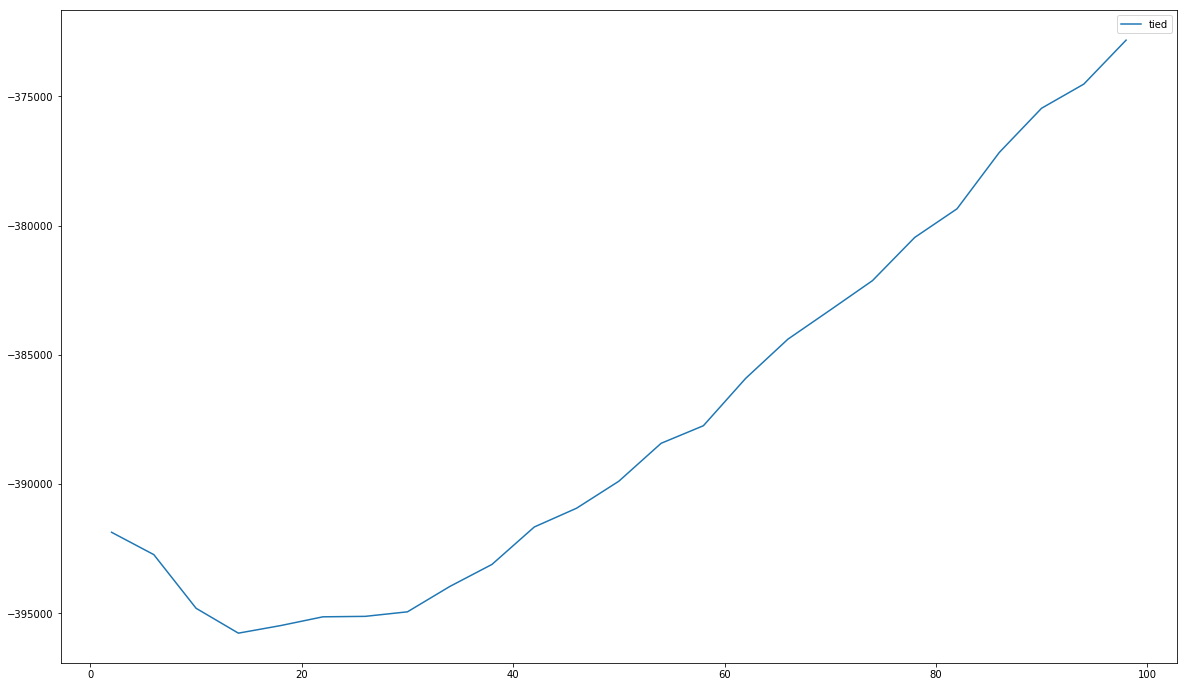

In [54]:
plt.figure(figsize=(20,12))
for cv_type in cv_types:
    plt.plot(x_axis, result[cv_type], label = cv_type)
plt.legend()
plt.show()

In [27]:
best_option

{'covariance_type': 'tied', 'n_components': 4}

In [15]:
gmm = GaussianMixture(**best_option)
gmm = gmm.fit(x)
print(gmm.bic(x))

-394478.70049442945


In [16]:
print(gmm.weights_.flatten() )
print(gmm.weights_.shape)
print("")
print(gmm.means_.flatten() )
print(gmm.means_.shape)
print("")
print(gmm.covariances_.flatten() )
print(gmm.covariances_.shape)
print("")
print(gmm.precisions_.flatten() )
print(gmm.precisions_.shape)

[0.38485724 0.17765868 0.15161497 0.28586911]
(4,)

[0.77350796 0.76406061 0.76570105 0.76007298 0.75673305 0.7619406
 0.7464742  0.72497605 0.71445689 0.70764999 0.70435329 0.69882187
 0.67937393 0.67243262 0.68147974 0.6906068  0.69413603 0.68123761
 0.67053271 0.68176072 0.70470545 0.70634421 0.69673357 0.73298073
 0.75736124 0.72888911 0.7006842  0.72889712 0.757216   0.76427199
 0.75324865 0.75867854 0.7669459  0.78045542 0.77644815 0.81698223
 0.84812434 0.82432168 0.752821   0.74168888 0.72699958 0.72776561
 0.75427275 0.77725177 0.76936238 0.75002856 0.74857842 0.77221598
 0.789039   0.76498944 0.74077327 0.75900474 0.75133991 0.73978717
 0.74322422 0.76332928 0.75401265 0.74703335 0.76780928 0.78070441
 0.78957667 0.76991141 0.74586093 0.75181263 0.74419163 0.72858916
 0.73781526 0.7572549  0.74853673 0.73687339 0.73804517 0.73383859
 0.73360655 0.72331645 0.72249712 0.7333087  0.72884811 0.71466683
 0.71164216 0.71814796 0.72678499 0.71965089 0.70766407 0.70758368
 0.85357208

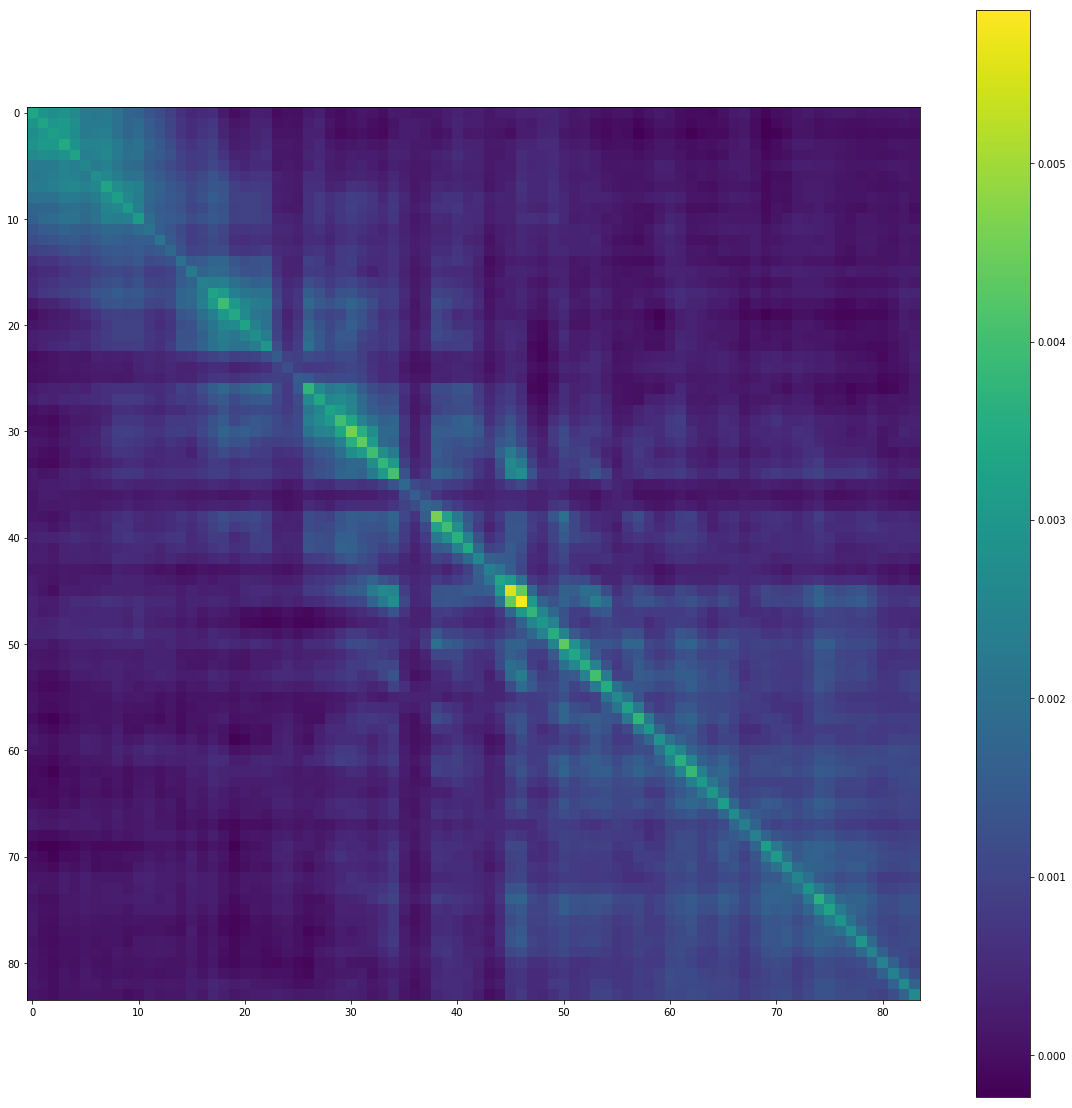

In [26]:
plt.figure(figsize=(20,20))
plt.imshow(gmm.covariances_)
plt.colorbar()
plt.show()

In [24]:
np.trace(gmm.covariances_)/np.sum(gmm.covariances_)

0.05580610902224205

- 'full' (each component has its own general covariance matrix),
- 'tied' (all components share the same general covariance matrix),
- 'diag' (each component has its own diagonal covariance matrix),
- 'spherical' (each component has its own single variance).

In [60]:
# for mfcc in tqdm.tqdm(glob.glob("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_audio/cqt/*.npy")):
#     filename = os.path.basename(mfcc)[:-4]
#     path = os.path.join("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_audio/gmm2", filename+".pkl")
#     if os.path.exists(path):
#         continue
        
#     x = np.load(mfcc)
#     x = np.swapaxes(x, 0, 1)
#     x -= x.min()
#     x /= x.max()
    
#     best_estimator = evaluate_gmms_opt(vec = x, 
#                                        n_gaussian = 100, 
#                                        covariance = ["tied"], 
#                                        step = 3, 
#                                        filename = filename)

# #     print(best_estimator)
    
#     gmm = GaussianMixture(**best_estimator)
#     gmm = gmm.fit(x)
#     if gmm.converged_ :
#         joblib.dump(gmm, path) 

In [50]:
def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X, _ = gmm_p.score_samples(X)
    log_q_X, _ = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y, _ = gmm_p.score_samples(Y)
    log_q_Y, _ = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return (log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2

In [51]:
gmm = None
gmm2 = None
for mdl_path in glob.glob("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_audio/gmm/*.pkl"):
    if gmm is None:
        gmm = joblib.load(mdl_path) 
    else:
        gmm2 = joblib.load(mdl_path)
        print(gmm_js(gmm, gmm2, 10**4))
        break
#     filename = os.path.basename(mdl_path)[:-4]
    
    

ValueError: too many values to unpack (expected 2)

In [56]:
a = gmm.sample(10**3)[0]
b = gmm.score_samples(a)
c = gmm2.score_samples(a)
d = np.logaddexp(b, c)

a2 = gmm2.sample(10**3)[0]
b2 = gmm.score_samples(a2)
c2 = gmm2.score_samples(a2)
d2 = np.logaddexp(b2, c2)

(a.mean() - (c.mean() - np.log(2))+ b2.mean() - (c2.mean() - np.log(2))) / 2

-80.2133239695553

In [46]:
b

array([169.59410749, 154.93889591, 152.2144647 , 155.77917198,
       163.16529063, 167.15142561, 161.24217618, 160.30188903,
       167.91058528, 166.64077867, 171.97849741, 162.82500995,
       170.58658882, 165.34890872, 161.07422904, 156.48562766,
       174.68513582, 167.45093335, 165.12610867, 164.3227082 ,
       171.25171251, 169.47655263, 172.45174669, 166.76353704,
       155.86204153, 173.38034709, 165.02266258, 158.40126374,
       169.03332644, 164.76025451, 164.23917942, 159.08482193,
       161.65495973, 168.16652188, 169.85627654, 162.03328032,
       155.29394533, 162.49640512, 155.88978058, 169.89750065,
       162.26220731, 169.43442708, 145.06104015, 162.84673527,
       161.66200988, 175.45562126, 161.28052042, 148.10116651,
       164.79819628, 160.64336381, 160.99646497, 174.33214541,
       169.18177717, 170.49555005, 173.50859675, 160.88306895,
       145.6959047 , 166.72054323, 162.52562457, 164.41243729,
       174.82837458, 158.66620631, 171.05474193, 153.49

In [47]:
c

array([123.47192608, 121.57535835, 113.07409769, 138.41292998,
       122.03434199, 128.86075209, 117.1642056 ,  98.03661951,
       142.38681031, 129.61818979, 142.10874198, 142.53017922,
       125.17911871, 128.71722946, 118.02433355,  97.3199104 ,
       138.22597501, 137.08198539, 132.80850922, 121.18306079,
       133.53590635, 141.42815575, 141.56474292, 141.66826229,
       131.92929623, 128.98748403, 131.02934865, 135.772083  ,
       138.65421749, 128.52575647, 138.56184078, 121.31404709,
       144.56687013, 135.47133865, 132.76410021, 115.89506023,
       112.23774074, 141.53263103, 130.99431224, 134.54043414,
       130.45691533, 132.55980529, 114.55326489, 127.42940923,
       122.589983  , 144.81369822, 124.03611747, 102.26050933,
       141.67440112, 113.63926083, 128.13607162, 139.11450054,
       144.23247723, 137.61911147, 141.28996374, 122.2095769 ,
       124.35034889, 137.13019865, 142.31087752, 147.32917385,
       142.82139702, 126.85890311, 137.06081336, 134.35

In [64]:
gmm.weights_ 

array([0.18031899, 0.25926973, 0.08082947, 0.15735667, 0.09095167,
       0.10878135, 0.12249212])

In [76]:
np.set_printoptions(precision=3)

In [86]:
a_diag = np.diag(gmm.covariances_)
a = gmm.covariances_ - np.diag(a_diag)
print(a.sum(axis=1))
print("")
print(a_diag)
print("")
print((a_diag / gmm.covariances_.sum(axis=1))**0.5)

[0.018 0.018 0.016 0.022 0.024 0.024 0.024 0.024 0.025 0.021 0.026 0.028
 0.028 0.027 0.023 0.029 0.03  0.038 0.034 0.03  0.028 0.034 0.038 0.03
 0.031 0.028 0.035 0.032 0.033 0.036 0.039 0.045 0.045 0.045 0.053 0.021
 0.012 0.021 0.048 0.041 0.039 0.038 0.033 0.03  0.042 0.067 0.069 0.043
 0.039 0.048 0.058 0.048 0.047 0.047 0.045 0.038 0.041 0.045 0.04  0.034
 0.046 0.056 0.061 0.046 0.045 0.048 0.044 0.037 0.042 0.05  0.05  0.051
 0.047 0.053 0.059 0.053 0.049 0.05  0.048 0.045 0.039 0.038 0.038 0.04 ]

[0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.002 0.002 0.002
 0.002 0.002 0.002 0.002 0.002 0.002 0.003 0.003 0.002 0.002 0.003 0.002
 0.002 0.002 0.003 0.003 0.003 0.003 0.003 0.004 0.004 0.003 0.004 0.002
 0.002 0.002 0.004 0.004 0.003 0.003 0.002 0.002 0.003 0.005 0.006 0.004
 0.003 0.003 0.004 0.003 0.003 0.004 0.003 0.003 0.003 0.004 0.003 0.003
 0.003 0.003 0.004 0.003 0.003 0.003 0.003 0.002 0.002 0.003 0.003 0.003
 0.002 0.003 0.004 0.003 0.003 0.003 0.003 0.002 0

In [87]:
print(gmm.weights_.flatten() )
print(gmm.weights_.shape)
print("")
print(gmm.means_ )
print(gmm.means_.shape)
print("")
print(gmm.covariances_.flatten() )
print(gmm.covariances_.shape)
print("")
print(gmm.precisions_.flatten() )
print(gmm.precisions_.shape)

[0.18  0.259 0.081 0.157 0.091 0.109 0.122]
(7,)

[[0.932 0.931 0.939 0.948 0.947 0.958 0.955 0.953 0.944 0.94  0.953 0.966
  0.967 0.962 0.943 0.897 0.922 0.933 0.92  0.885 0.893 0.909 0.905 0.897
  0.903 0.889 0.895 0.881 0.848 0.868 0.876 0.869 0.858 0.829 0.829 0.845
  0.849 0.851 0.83  0.816 0.809 0.786 0.804 0.822 0.824 0.809 0.807 0.818
  0.832 0.822 0.802 0.798 0.787 0.772 0.767 0.777 0.775 0.766 0.772 0.779
  0.798 0.786 0.775 0.77  0.757 0.753 0.766 0.781 0.776 0.764 0.761 0.759
  0.77  0.756 0.745 0.75  0.743 0.733 0.728 0.74  0.737 0.729 0.718 0.717]
 [0.745 0.735 0.737 0.728 0.723 0.733 0.716 0.689 0.68  0.678 0.68  0.679
  0.66  0.656 0.669 0.677 0.681 0.665 0.651 0.671 0.693 0.698 0.687 0.726
  0.751 0.724 0.689 0.715 0.744 0.749 0.734 0.746 0.759 0.776 0.767 0.813
  0.848 0.824 0.746 0.731 0.716 0.722 0.747 0.776 0.768 0.746 0.74  0.765
  0.782 0.754 0.731 0.752 0.746 0.734 0.736 0.759 0.751 0.743 0.765 0.775
  0.783 0.763 0.742 0.749 0.74  0.721 0.731 0.752 0.743 0.734

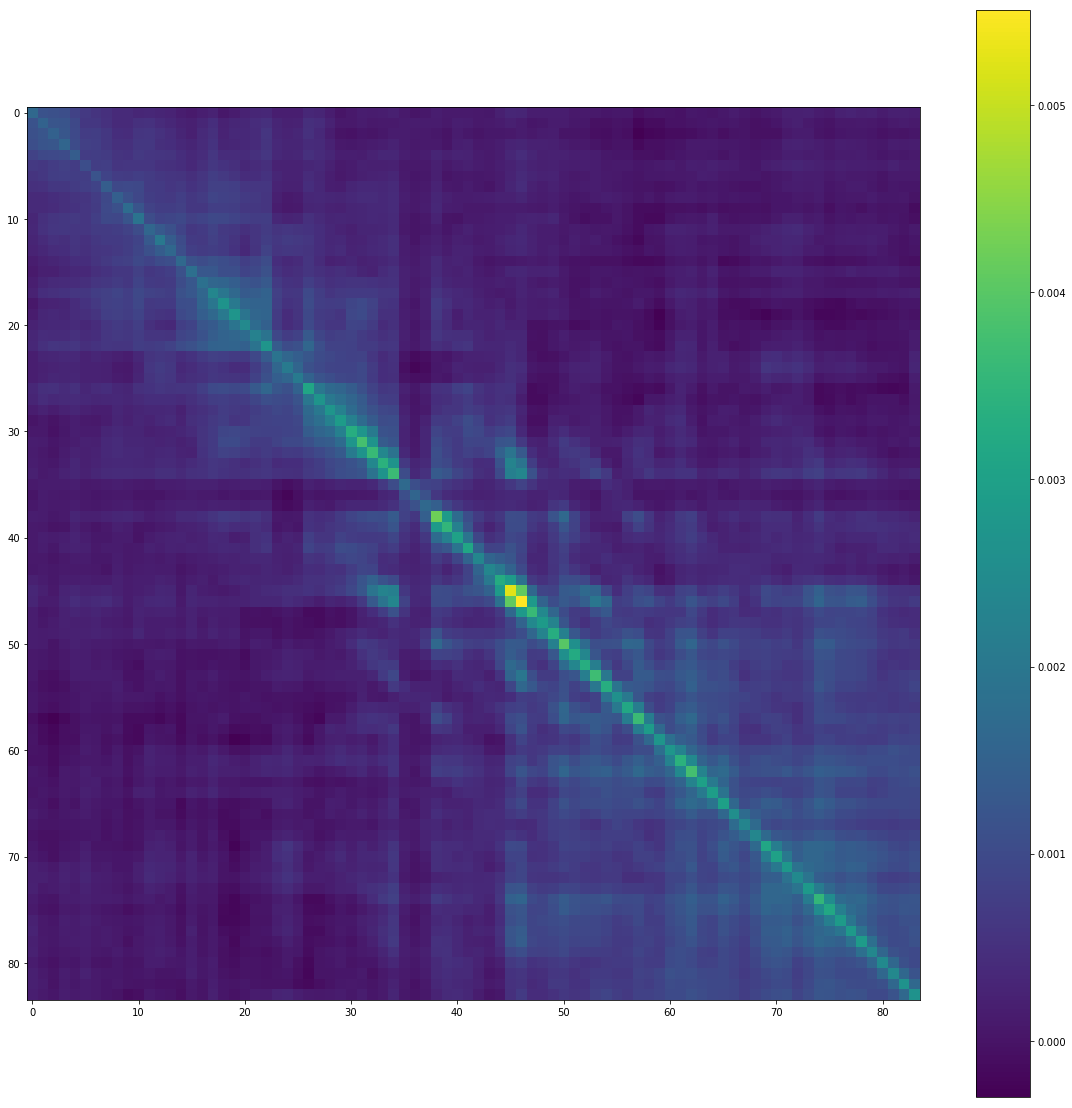

In [68]:
plt.figure(figsize=(20,20))
plt.imshow(gmm.covariances_)
plt.colorbar()
plt.show()